# Basic usage

This tutorial will introduce you to the definition of the building blocks for your
boson sampling experiment. The general workflow for a simple simulation is to define
an [`Input`](@ref) that enters into a [`Interferometer`](@ref) and ask what is the
probability to get a defined [`OutputMeasurement`](@ref).

They are linked together through an [`Event`](@ref) type, which holds the respective probabilities. As the computation of probabilities is often the most time consuming step, you need to explicitly ask for it through [`compute_probability!`](@ref) which updates the [`EventProbability`](@ref) data.


## Input

`BosonSampling.jl` provides three distinct types of input depending on the
distinguishability of the particles we want to make interfere: [`Bosonic`](@ref),
[`PartDist`](@ref) and [`Distinguishable`](@ref). The type [`PartDist`](@ref) is a container for different models of partial distinguishability. Currently available models are:
* [`OneParameterInterpolation`](@ref)
* [`RandomGramMatrix`](@ref)
* [`UserDefinedGramMatrix`](@ref)
* [`Undef`](@ref)

In order to define the input, we first need to provide a [`ModeOccupation`](@ref) that describes the repartition of the particles among the modes.

In [33]:
using BosonSampling
using Plots

In [2]:
n = 3; # photon number
m = 6; # mode number

my_mode_occupation = ModeOccupation(random_occupancy(n,m))

state = [0, 0, 0, 2, 0, 1]

In the example above, `my_mode_occupation` has been created thanks to [`random_occupancy`](@ref) that randomly places `n` particles among `m` modes. Here we have one particle in the first, fourth and fifth modes.
Let's build an input made off indistinguishable photons by using the type [`Bosonic`](@ref)

In [3]:
my_input = Input{Bosonic}(my_mode_occupation)

Input{Bosonic}(state = [0, 0, 0, 2, 0, 1], 3, 6, GramMatrix{Bosonic}(3, ComplexF64[1.0 + 0.0im 1.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 1.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 1.0 + 0.0im 1.0 + 0.0im], nothing, nothing, OrthonormalBasis(nothing)), nothing)

where `my_input` holds the information defined above and an additional field, the [`GramMatrix`](@ref):

In [4]:
?GramMatrix

search: GramMatrix gram_matrix_one_param RandomGramMatrix rand_gram_matrix



```
GramMatrix{T}(n::Int) where {T<:InputType}
GramMatrix{T}(n::Int, distinguishability_param::Real) where {T<:InputType}
GramMatrix{T}(n::Int, S::Matrix) where {T<:InputType}
```

Matrix of partial distinguishability. Will automatically generate the proper matrix related to the provided [`InputType`](@ref).

```
Fields:
    - n::Int: photons number
    - S::Matrix: Gram matrix
    - rank::Union{Int, Nothing}
    - distinguishability_param::Union{Real, Nothing}
    - generating_vectors::OrthonormalBasis
```


In [39]:
fieldnames(Event)

(:input_state, :output_measurement, :proba_params, :interferometer)

In [42]:
?RealisticDetectorsFockSample

search: RealisticDetectorsFockSample



```
RealisticDetectorsFockSample(p_dark::Real, p_no_count::Real)
```

Same as [`DarkCountFockSample`](@ref) with the added possibility that no reading is observed although there is a photon. This same probability also removes dark counts (first a dark count sample is generated then readings are discarded with probability `p_no_count`).


In [43]:
?FockSample

search: FockSample DarkCountFockSample RealisticDetectorsFockSample



```
FockSample <: OutputMeasurementType
```

Container holding a sample from typical boson sampler.


which contains everything about the distinguishability of the particles within `my_input`. The matrix itself can be accessed via the field `S`:

In [5]:
my_input.G.S

3×3 Matrix{ComplexF64}:
 1.0+0.0im  1.0+0.0im  1.0+0.0im
 1.0+0.0im  1.0+0.0im  1.0+0.0im
 1.0+0.0im  1.0+0.0im  1.0+0.0im

One can do the same for [`Distinguishable`](@ref) particles placed in the [`first_modes`](@ref)

In [6]:
my_mode_occupation = first_modes(n,m);

my_input = Input{Distinguishable}(my_mode_occupation);

my_input.G.S

3×3 Matrix{ComplexF64}:
 1.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  1.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im

We can move now to the [`PartDist`](@ref) case with a model of partially distinguishable particles defined by a [`RandomGramMatrix`](@ref)

In [7]:
my_input = Input{RandomGramMatrix}(first_modes(n,m))

Input{RandomGramMatrix}(state = [1, 1, 1, 0, 0, 0], 3, 6, GramMatrix{RandomGramMatrix}(3, ComplexF64[1.0 + 0.0im 0.7066727302676918 - 0.30292597145145506im 0.7340077025690823 + 0.11013786956836874im; 0.7066727302676918 + 0.30292597145145506im 0.9999999999999999 + 0.0im 0.7218278542441346 + 0.4916620248708677im; 0.7340077025690823 - 0.11013786956836874im 0.7218278542441346 - 0.4916620248708677im 1.0 + 0.0im], nothing, nothing, OrthonormalBasis(nothing)), nothing)

where `my_input.G.S` is a randomly generated Gram matrix.

Finally, one can resort to a [`OneParameterInterpolation`](@ref) model taking a linear distinguishability
parameter as an additional argument in the definition of `my_input`:

In [8]:
my_mode_occupation = ModeOccupation(random_occupancy(n,m));

my_distinguishability_param = 0.7;

my_input = Input{OneParameterInterpolation}(my_mode_occupation, my_distinguishability_param)

Input{OneParameterInterpolation}(state = [0, 0, 0, 2, 0, 1], 3, 6, GramMatrix{OneParameterInterpolation}(3, [1.0 0.7 0.7; 0.7 1.0 0.7; 0.7 0.7 1.0], nothing, 0.7, OrthonormalBasis(nothing)), 0.7)

Notice that the [`Bosonic`](@ref) Gram matrix is recovered for `my_distinguishability_param = 1`
while we find the [`Distinguishable`](@ref) case for `my_distinguishability_param = 0`.  

## Interferometer

The second building block of our boson sampler is the interferometer
we want to apply on `my_input`. A common practice to study boson sampling is to
pick up at random a Haar distributed unitary matrix that will represent the interferometer.
This can be done as follow:

In [9]:
my_random_interf = RandHaar(m);

my_random_interf.U

6×6 Matrix{ComplexF64}:
 -0.261717-0.32965im   -0.344292-0.0404349im  …   0.398573+0.331492im
 -0.208785-0.448637im  -0.392232+0.190346im       0.200925-0.163829im
  0.457423-0.141612im  -0.229379+0.0708311im      0.154988-0.176772im
  0.189825+0.102093im  -0.585728+0.214754im      -0.550915-0.126376im
  0.480885-0.145053im   0.259174+0.386741im       0.161418-0.25216im
 -0.196152-0.107032im  -0.152068-0.0552985im  …  -0.446507-0.0168888im

where we have accessed to the matrix thanks to the field `.U`.
We may also need to use a specific interferometer such as a [`Discrete Fourier Transform`](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) or the [`Hadamard transform`](https://en.wikipedia.org/wiki/Hadamard_transform):

In [10]:
my_fourier_interf = Fourier(m);

is_unitary(my_fourier_interf.U)

true

In [11]:
my_hadamard_tf = Hadamard(2^m);

is_unitary(my_hadamard_tf.U)

true

where we have checked the unitarity thanks to `is_unitary`.

The implemented interferometers are listed in [`Interferometer`](@ref) but it is still
possible to define our own unitary by resorting to the type [`UserDefinedInterferometer`](@ref):

In [12]:
sigma_y = [0 -1im; 1im 0];

my_interf = UserDefinedInterferometer(sigma_y)

Interferometer :

Type : UserDefinedInterferometer
m : 2
Unitary : 
┌────────┬────────┐
│ Col. 1 │ Col. 2 │
├────────┼────────┤
│  0+0im │  0-1im │
│  0+1im │  0+0im │
└────────┴────────┘


## OutputMeasurement

Now consider what you want to observe, in this numerical experiment. If looking at the case of a single output, we would use an [`OutputMeasurement`](@ref) type called [`FockDetection`](@ref). Other types are currently defined such as [`PartitionCount`](@ref), which would evaluate the probability of finding a photon count in a partition of the output modes.

Similary to the definition of the [`Input`](@ref), it is also possible to define an output configuration from a [`ModeOccupation`](@ref)

In [13]:
n = 3;

m=n^2;

my_mode_occupation = first_modes(n,m);

my_input = Input{Bosonic}(my_mode_occupation)

out = FockDetection(my_mode_occupation)

FockDetection(state = [1, 1, 1, 0, 0, 0, 0, 0, 0])

using [`FockDetection`](@ref). Additionally, we can define an [`Event`](@ref) that stores our input-interferometer-output content

In [14]:
my_interf = Fourier(my_input.m)
ev = Event(my_input, out, my_interf)

Event{Bosonic, FockDetection}(Input{Bosonic}(state = [1, 1, 1, 0, 0, 0, 0, 0, 0], 3, 9, GramMatrix{Bosonic}(3, ComplexF64[1.0 + 0.0im 1.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 1.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 1.0 + 0.0im 1.0 + 0.0im], nothing, nothing, OrthonormalBasis(nothing)), nothing), FockDetection(state = [1, 1, 1, 0, 0, 0, 0, 0, 0]), EventProbability(nothing, nothing, nothing), Interferometer :

Type : Fourier
m : 9
U : 
ComplexF64[0.3333333333333333 + 0.0im 0.3333333333333333 + 0.0im … 0.3333333333333333 + 0.0im 0.3333333333333333 + 0.0im; 0.3333333333333333 + 0.0im 0.25534814770632597 + 0.21426253656217975im … 0.05788272588897665 - 0.32826925100406934im 0.2553481477063259 - 0.21426253656217986im; … ; 0.3333333333333333 + 0.0im 0.05788272588897665 - 0.32826925100406934im … -0.3132308735953023 + 0.11400671444189098im 0.057882725888977804 + 0.3282692510040691im; 0.3333333333333333 + 0.0im 0.2553481477063259 - 0.21426253656217986im … 0.057882725888977804 + 0.3282692510040691im 0.25

and then one can compute the probability that this event occurs

In [15]:
compute_probability!(ev)

0.015964548319225575

Those steps can be repeated for different types of input. Let's say we want to
compute the probability that partially distinguishable photons populating the `n=3`
first modes of `m=9` modes end up in the `n` last output modes when interfering through
a random interferometer:

In [16]:
my_input = Input{RandomGramMatrix}(first_modes(n,m)); # input from a randomly generated Gram matrix

out = FockDetection(ModeOccupation([0,0,0,0,0,0,1,1,1]));

my_interf = RandHaar(m);

ev = Event(my_input, out, my_interf);

compute_probability!(ev)

0.0001713859412777654

## Using the BosonSampling types

Julia allows to define functions that act on new types, such as [`ModeOccupation`](@ref) defined in this package, through a syntax that would otherwise be reserved for core-objects such as `Float`, `Int`.

This allows to intuitively act on custom types. For instance, two [`ModeOccupation`](@ref) can see their state summed by simply using `+`


In [17]:
n=3
m=4
s1 = ModeOccupation([1,2,3,4])
s2 = ModeOccupation([1,0,1,0])

s1+s2

state = [2, 2, 4, 4]

Some functions of interest are [`zeros(mo::ModeOccupation)`](@ref), [`Base.cat(s1::ModeOccupation, s2::ModeOccupation)`](@ref) for instance.

# Sampling

Let's now use boson samplers with a realistic detector (see properties in Documentation)

In [18]:
n = 10
m = 10

p_dark = 0.1
p_no_count = 0.1

input_state = first_modes(n,m)
interf = RandHaar(m)

i = Input{Bosonic}(input_state)
o = RealisticDetectorsFockSample(p_dark, p_no_count)
ev = Event(i,o,interf)

sample!(ev)


state = [0, 0, 0, 3, 2, 2, 0, 1, 3, 0]

this works intelligently for different types of inputs, detectors with the same `sample!` function

In [20]:
i = Input{Distinguishable}(input_state)
o = FockSample()
ev = Event(i,o,interf)

sample!(ev)

state = [1, 1, 0, 1, 0, 0, 0, 1, 1, 5]

# Circuits

Let's now see how to build optical circuits from elementary optical elements such as beam splitters. We first define an empty circuit, then add elements as follows

In [22]:
n = 3
m = n

circuit = LosslessCircuit(m)
interf = BeamSplitter(1/sqrt(2)) # the element we add
target_modes = [1, 2] # acting on the first two modes
add_element!(circuit, interf, target_modes = target_modes)

┌───────────┬───────────┬───────────┐
│    Col. 1 │    Col. 2 │    Col. 3 │
├───────────┼───────────┼───────────┤
│ 1.0+0.0im │ 0.0+0.0im │ 0.0+0.0im │
│ 0.0+0.0im │ 1.0+0.0im │ 0.0+0.0im │
│ 0.0+0.0im │ 0.0+0.0im │ 1.0+0.0im │
└───────────┴───────────┴───────────┘
pretty_table(circuit.U) = nothing
┌────────────────┬─────────────────┬───────────┐
│         Col. 1 │          Col. 2 │    Col. 3 │
├────────────────┼─────────────────┼───────────┤
│ 0.707107+0.0im │ -0.707107+0.0im │ 0.0+0.0im │
│ 0.707107+0.0im │  0.707107+0.0im │ 0.0+0.0im │
│      0.0+0.0im │       0.0+0.0im │ 1.0+0.0im │
└────────────────┴─────────────────┴───────────┘
pretty_table(u) = nothing
┌────────────────┬─────────────────┬───────────┐
│         Col. 1 │          Col. 2 │    Col. 3 │
├────────────────┼─────────────────┼───────────┤
│ 0.707107+0.0im │ -0.707107+0.0im │ 0.0+0.0im │
│ 0.707107+0.0im │  0.707107+0.0im │ 0.0+0.0im │
│      0.0+0.0im │       0.0+0.0im │ 1.0+0.0im │
└────────────────┴─────────────────┴─

# Loss

Loss can be incorporated through [`BeamSplitter`](@ref)'s sending photons with some probability to extra environment modes. If a physical [`Interferometer`](@ref) has `m` modes, we create extra `m` modes representing lost photons. In reality, these would not be accessible, but we may still keep this information if necessary. This allows to post-select events upon a certain loss pattern, such as finding `l` (lost) photons in the environment modes.

## Conversions

In general, the function [`to_lossy`](@ref) converts physical `m`-mode objects into their `2m`-modes counterpart fitting the above model. For instance

In [25]:
n=3
m=4
first_modes(n,m)

state = [1, 1, 1, 0]

In [26]:
to_lossy(first_modes(n,m))

state = [1, 1, 1, 0, 0, 0, 0, 0]

In [30]:
# creating a Subset:
Subset(first_modes(n,m))

subset = [1, 2, 3]

In [29]:
# expanding it doesn't change the Subset
to_lossy(Subset(first_modes(n,m)))

subset = [1, 2, 3]

In [31]:
# but it is now of the correct size
to_lossy(Subset(first_modes(n,m))).m

8

## Conventions

Each circuit element, such as [`BeamSplitter`](@ref) and [`PhaseShift`](@ref) can bear a certain amount of loss. We write it `η_loss`. It is the transmission amplitude of the beam splitter representing the loss process. Therefore the probability that a photon is not lost is `η_loss^2`.

## Lossy interferometers

The inclusion of loss creates bigger [`Interferometer`](@ref)'s, but half of their modes are not physical. For this reason, we use the subtype [`LossyInterferometer`](@ref).

The fields are named in such a way that all computations can be done without changes, as if we now used a `2m*2m` lossless interferometer. The physical quantities are labelled accordingly such as `m_real` and `U_physical`.

## Models implemented

Let us now discuss the various lossy elements available.
* [`UniformLossInterferometer`](@ref) : This simplest model is one where photons have an identical chance of being lost.
* [`GeneralLossInterferometer`](@ref) This is a generic model as described in ...
* Lossy circuit elements : When constructing a [`Circuit`](@ref) from elements, each element has its own loss characteristics. We also introduce lines, representing for instance optical fibers that have no interaction but can still be lossy.

## Circuits

When using `circuit_elements` to construct a lossy interferometer, the loss channel associated to mode `i` will always be mode `m+i`.

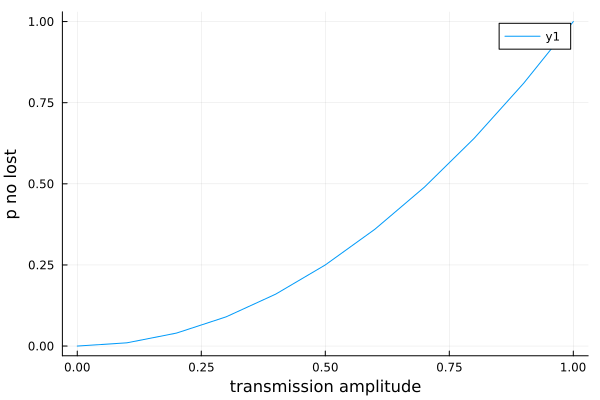

In [36]:

n = 1
m = 1

function lossy_line_example(η_loss)

    circuit = LossyCircuit(1)
    interf = LossyLine(η_loss)
    target_modes = [1]

    add_element_lossy!(circuit, interf, target_modes = target_modes)
    circuit

end

lossy_line_example(0.9)

transmission_amplitude_loss_array = 0:0.1:1
output_proba = []

i = Input{Bosonic}(to_lossy(first_modes(n,m)))
o = FockDetection(to_lossy(first_modes(n,m)))

for transmission in transmission_amplitude_loss_array

    ev = Event(i,o, lossy_line_example(transmission))
    compute_probability!(ev)
    push!(output_proba, ev.proba_params.probability)
end

plot(transmission_amplitude_loss_array, output_proba)
ylabel!("p no lost")
xlabel!("transmission amplitude")

converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy
converting Input to lossy
converting Output to lossy


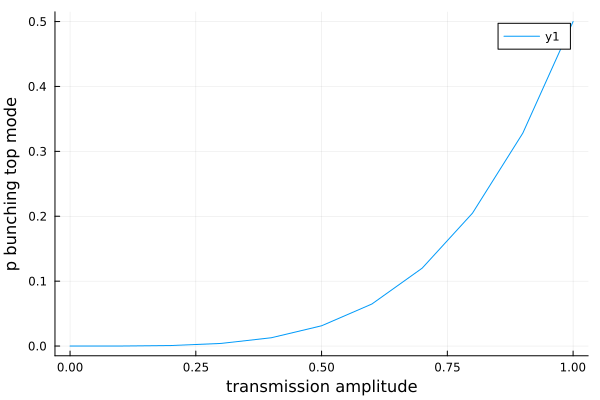

In [37]:
n = 2
m = 2
i = Input{Bosonic}(first_modes(n,m))
o = FockDetection(ModeOccupation([2,0])) # detecting bunching, should be 0.5 in probability if there was no loss
transmission_amplitude_loss_array = 0:0.1:1
output_proba = []

function lossy_bs_example(η_loss)

    circuit = LossyCircuit(2)
    interf = LossyBeamSplitter(1/sqrt(2), η_loss)
    target_modes = [1,2]

    add_element_lossy!(circuit, interf, target_modes = target_modes)
    circuit

end

for transmission in transmission_amplitude_loss_array

    ev = Event(i,o, lossy_bs_example(transmission))
    compute_probability!(ev)
    push!(output_proba, ev.proba_params.probability)
end

plot(transmission_amplitude_loss_array, output_proba)
ylabel!("p bunching top mode")
xlabel!("transmission amplitude")